In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import time
import music_data_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels=4, hidden_dim=350, n_layers=3):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        ## in_channels represents the number of features 
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lstm = nn.LSTM(
            input_size = self.in_channels, hidden_size = self.hidden_dim,
            num_layers = self.n_layers, batch_first = True
        )
        # We want the output to be a sequence of seq_length in which each value in the sequence
        # has 4 channels. Therefore, we'll need a tensor of size batch_size*seq_length*num_channels
        # For that, we need a linear layer that receives a tensor of size (batch_size, seq_length, hidden_dim)
        # and returns a tensor of size (batch_size, seq_length, out_channels)
        self.fc = nn.Linear(in_features = self.hidden_dim, out_features = self.out_channels)
        
    def forward(self, x, h=None):
        if (h==None):
            lstm_output, hidden = self.lstm(x)
        else:
            lstm_output, hidden = self.lstm(x, h)
        # Stack up LSTM outputs
        out = lstm_output.reshape(-1, self.hidden_dim) 
        out = self.fc(out)
        return out, hidden

In [5]:
class Discriminator(nn.Module):
    def __init__(self, out_size=2, in_channels=4, hidden_dim=350, n_layers=2):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.in_channels = in_channels
        self.out_size = out_size
        self.lstm = nn.LSTM(
            input_size = in_channels, hidden_size = self.hidden_dim,
            num_layers = self.n_layers, batch_first = True
        )
        self.fc = nn.Linear(in_features = self.hidden_dim, out_features = 2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, seq_length, h=None):
        # I could just get seq_length out of x's shape, but it's easier to pass
        # it as an argument to the function.
        if (h==None):
            out, hidden = self.lstm(x)
        else:
            out, hidden = self.lstm(x, h)
        # output of shape (seq_len, batch, num_directions * hidden_size)
        out = out.reshape(-1, seq_length, self.hidden_dim)
        out = self.logsoftmax(self.fc(out))
        
        # return the final output and the hidden state
        return out, hidden

In [217]:
class CRNNGAN():
    def __init__(self, batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 epochs = 15, lr_g = 0.1, lr_d = 0.1, beta_g = 0.5, beta_d = 0.5,
                 curriculum_learning = False, seq_length_increments = 5,
                 G_var_threshold = 0.01, D_var_threshold = 0.01,
                 max_sequence_length = 100, print_every=10):
        self.batch_length = batch_length
        self.sequence_length = sequence_length
        self.in_channels_g = in_channels_g
        self.out_channels_g = out_channels_g
        self.hidden_dim_g = hidden_dim_g
        self.n_layers_g = n_layers_g
        self.in_channels_d = in_channels_d
        self.out_channels_d = out_channels_d
        self.hidden_dim_d = hidden_dim_d
        self.n_layers_d = n_layers_d
        
        self.epochs = epochs
        self.lr_g = lr_g
        self.lr_d = lr_d
        self.beta_g = beta_g
        self.beta_d = beta_d
        
        self.curriculum_learning = curriculum_learning
        self.seq_length_increments = seq_length_increments
        self.max_sequence_length = max_sequence_length
        
        self.netG = Generator(
            in_channels=self.in_channels_g, out_channels=self.out_channels_g,
            hidden_dim=self.hidden_dim_g, n_layers=self.n_layers_g
        )
        self.netD = Discriminator(
            in_channels=self.in_channels_d, out_size=self.out_channels_d,
            hidden_dim=self.hidden_dim_d, n_layers=self.n_layers_d
        )
        
        self.criterion = nn.NLLLoss()
        
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=self.lr_g, betas=(self.beta_g, 0.999))
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=self.lr_d, betas=(self.beta_d, 0.999))
        
        self.G_losses = []
        self.D_losses = []
        self.G_losses_variance = []
        self.G_var_threshold = G_var_threshold
        self.D_losses_varaince = []
        self.D_var_threshold = D_var_threshold
        self.generated_songs = []
        self.fixed_noises = [torch.randn(self.batch_length, self.in_channels_g, self.sequence_length, 1, 1)]
        
        self.print_every = print_every
        
    def trainloop(self, dataLoader):
        print('Start training for {} epochs'.format(self.epochs))
        iters = 0
        iters_per_epoch = 0
        for epoch in range(self.epochs):
            start_time = time.time()
            ## Reset data loader to load new batches
            dataLoader.rewind('train')
            ## We only care about the four variables obtain from the midi file (we can scrap the metadata)
            _, batch_data = dataLoader.get_batch(batchsize=self.batch_length, songlength=self.sequence_length)
            ## Since there's no "easy" way of obtaining the number of batches, we'll loop until there are no
            ## more batches, i.e. a batch is None
            while batch_data is not None:
                ### First we train the Discriminator Network
                ## Real Data
                self.netD.zero_grad()
                # Construct a (batch_length, 2) long tensor with all zeroes in the first column
                # and all ones in the second one
                label_real = torch.full((self.batch_length,2), 1).long()
                label_real[:,0] = 0
                
                # Here the data does not come as a tensor and therefore we have to convert it
                output_real, _ = self.netD.forward(
                    torch.FloatTensor(batch_data), 
                    seq_length=self.sequence_length
                )
                loss_real = self.criterion(output_real, label_real)
                loss_real.backward()
                # Since the class according to the model is the one with a larger value,
                # we'll take the mean of the max on a row basis. (The output has a shape
                # which is (batch_lenght, 2), and the class (fake/real) is determined as
                # the larger of the two columns).
                D_x = torch.max(output_real, dim=1)[0].mean().item()
                
                ## Fake Data
                # Generate noise (self.in_channels_g determines how the noise is to be created)
                noise = torch.randn(self.batch_length, self.in_channels_g, self.sequence_length, 1, 1)
                # label_fake is just label_real with the columns swapped
                label_fake = torch.index_select(label_real, 1, torch.LongTensor([1, 0]))
                
                # Get the fake sequence out of the generator
                fake_data, _ = self.netG.forward(noise.reshape(-1, 1, self.in_channels_g))
                
                # Get the output for the discriminator
                output_fake, _ = self.netD.forward(
                    fake_data.reshape(self.batch_length, self.sequence_length, 4),
                    self.sequence_length
                )
                loss_fake = self.criterion(output_fake, label_fake)
                # Here we call retain graph so that it isn't lost after calling the optimizer
                # for the discriminator, as we will need part of the graph to be used again
                # for the generator's optimizer.
                loss_fake.backward(retain_graph=True)
                D_G_z1 = torch.max(output_fake, dim=1)[0].mean().item()
                # Add gradients from real and fake batches
                loss_discriminator = loss_real + loss_fake
                self.optimizerD.step()
                
                ### Now, we train the Generator Network
                self.netG.zero_grad()
                # From the generator's cost point of view fake labels are real labels and vice-versa
                label_fake = label_real
                
                # Output of the discriminator network with fake data
                output_fake, _ = self.netD.forward(
                    fake_data.reshape(self.batch_length, self.sequence_length, 4),
                    self.sequence_length
                )
                loss_fake_G = self.criterion(output_fake, label_fake)
                loss_fake_G.backward()
                D_G_z2 = torch.max(output_fake, dim=1)[0].mean().item()
                self.optimizerG.step()
                
                if iters % int(self.print_every) == 0:
                    print('[%d/%d][%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.2f\n Time since epoch started: %.2f'
                          % (epoch, self.epochs, iters,
                             loss_discriminator.item(), loss_fake_G.item(), 
                             D_x, D_G_z1, D_G_z2, 
                             time.time()-start_time))
                    print('There are a total of {} fake songs saved already'.format(len(self.generated_songs)))
            
                self.G_losses.append(loss_fake_G.item())
                self.D_losses.append(loss_discriminator.item())
                count = 10 if iters > 10 else iters
                if self.curriculum_learning:
                    self.G_losses_variance.append(np.var(self.G_losses[-count:]))
                    self.D_losses_varaince.append(np.var(self.D_losses[-count:]))
            
                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 2 == 0) or ((epoch == self.epochs-1)):
                    with torch.no_grad():
                        fake, _ = self.netG.forward(self.fixed_noises[-1].reshape(-1, 1, self.in_channels_g))
                        self.generated_songs.append(fake.reshape(self.batch_length, self.sequence_length, 4))
                
                iters += 1
                iters_per_epoch += 1
                _, batch_data = dataLoader.get_batch(batchsize=self.batch_length, songlength=self.sequence_length)
            if self.curriculum_learning and (
                np.mean(self.G_losses_variance[-iters_per_epoch:]) < self.G_var_threshold and
                np.mean(self.D_losses_varaince[-iters_per_epoch:]) < self.D_var_threshold
            ):
            ## Instead of the mean of the variances I could just update the sequence length if 70% of the variances
            ## are below a certain threshold
            #if (self.curriculum_learning and (
            #    sum(np.asarray(self.G_losses_variance[-iters_per_epoch:]) < self.G_var_threshold)/iters_per_epoch >= 0.7 and
            #    sum(np.asarray(self.D_losses_varaince[-iters_per_epoch:]) < self.D_var_threshold)/iters_per_epoch >= 0.7
            #)):
                if (self.sequence_length < self.max_sequence_length):
                    self.sequence_length += self.seq_length_increments
                    print('New sequence length: ', self.sequence_length, ' modified on iteration ', iters)
                    print('The variances were {:.5f} for G and {:.5f} for D'.format(self.G_losses_variance[-1], self.D_losses_varaince[-1]))
                    self.fixed_noises.append(torch.randn(self.batch_length, self.in_channels_g, self.sequence_length, 1, 1))
                else:
                    print('Maximum sequence reached')
                    print('Here maybe we could modify the learning rate...')
            iters_per_epoch = 0
            print('Epoch time: {:.2f}'.format(time.time()-start_time))

In [33]:
batch_length = 100
sequence_length = 30
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
### In the paper they indicate they've done it with 2, but it does not seem enough to get the complexity
### of the data.
n_layers_g = 3
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2

crnngan = CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d)

In [15]:
# Get the data loader
musicDataLoader = music_data_utils.MusicDataLoader('./music_data', 0.2, 0.1)

Data loader: datadir: ./music_data
num genres:1
num composers: 154
limit works per composer: None
appending classical/adam/3003marquise.mid
appending classical/adam/3002robdia.mid
appending classical/adam/3000adamno_l.mid
appending classical/aguado/agupolo.mid
appending classical/aguado/AguadoMenuet1Op12.mid
appending classical/aguado/AguadoLessonNo1.mid
appending classical/aguado/aguadron.mid
appending classical/aguado/AguadoMenuet3Op12.mid
appending classical/albenizisaac/1149albcot.mid
appending classical/albenizisaac/1155asturian.mid
appending classical/albenizisaac/1151alb1gav.mid
appending classical/albenizisaac/1152albzgrda.mid
appending classical/albenizisaac/110.mid
appending classical/albenizisaac/39.mid
appending classical/albenizisaac/albesp5.mid
appending classical/albenizisaac/albesp4.mid
appending classical/albenizisaac/albesp6.mid
appending classical/albenizisaac/albesp3.mid
appending classical/albenizisaac/1148aicuba.mid
appending classical/albenizisaac/albesp2.mid
app

appending classical/debussy/71.mid
appending classical/debussy/303debpt2.mid
appending classical/debussy/102.mid
appending classical/debussy/4ballet.mid
appending classical/debussy/94arab1.mid
appending classical/debussy/12.mid
appending classical/debussy/94arab2.mid
appending classical/debussy/695gpclair.mid
appending classical/debussy/2cortege.mid
appending classical/debussy/323debutc3.mid
appending classical/debussy/423reveried.mid
appending classical/debussy/118.mid
appending classical/debussy/321debutc2.mid
appending classical/debussy/324child1.mid
appending classical/debussy/209.mid
appending classical/debussy/394masqu2e.mid
Path does not exist: ./music_data/classical/delibes
appending classical/delius/1865sleigh.mid
appending classical/delius/467badinage.mid
appending classical/delius/1887irmelin.mid
appending classical/delius/468closin.mid
appending classical/delius/1848cuckoo.mid
appending classical/delius/473serenade3.mid
appending classical/delius/472zum.mid
appending classi

appending classical/pachelbel/1687tpvent10w.mid
appending classical/pachelbel/1685tpvent8w.mid
appending classical/pachelbel/1690tpvent13w.mid
appending classical/pachelbel/1704tpinven13.mid
appending classical/pachelbel/1705tpinven14.mid
appending classical/pachelbel/112.mid
appending classical/pachelbel/106.mid
appending classical/pachelbel/2439tmtoccfg.mid
appending classical/pachelbel/2800gottes.mid
appending classical/pachelbel/348baw101f.mid
appending classical/pachelbel/1698tpinven7.mid
appending classical/pachelbel/406bach2-12.mid
appending classical/pachelbel/1703tpinven12.mid
appending classical/pachelbel/1717tpvent14w.mid
appending classical/pachelbel/2653sicilianos766.mid
appending classical/pachelbel/1701tpinven10.mid
appending classical/pachelbel/1696tpinven5.mid
appending classical/pachelbel/1679tpvent2w.mid
appending classical/pachelbel/1668bachvari.mid
appending classical/pachelbel/1673tpvnt15w.mid
appending classical/pachelbel/109.mid
appending classical/pachelbel/169

Reading files classical/adam: 3
Reading files classical/aguado: 5
Reading files classical/albenizisaac: 20
Reading files classical/albenizmateo: 2
Reading files classical/albinoni: 1
Reading files classical/alford: 2
Reading files classical/alkan: 11
Reading files classical/anderson: 8
Reading files classical/ansell: 1
Reading files classical/arensky: 5
Reading files classical/arriaga: 2
Reading files classical/bach: 100
Reading files classical/bach: 200
Reading files classical/bach: 300
Reading files classical/bach: 360
Reading files classical/barber: 8
Path does not exist: ./music_data/classical/barbieri
Reading files classical/bartok: 99
Reading files classical/bax: 2
Error reading ./music_data/classical/beethoven/14715thSympnmov1.mid
Reading files classical/beethoven: 68
Reading files classical/bellini: 4
Reading files classical/bergmuller: 48
Reading files classical/berlin: 3
Reading files classical/berlioz: 3
Reading files classical/binge: 3
Reading files classical/bizet: 17
Path

In [34]:
crnngan.trainloop(musicDataLoader)

Start training for 15 epochs
[0/15][0]	Loss_D: 6.7752	Loss_G: 4.1832	D(x): -3.3579	D(G(z)): -3.4005 / -0.0002
 Time since epoch started: 3.46
[0/15][10]	Loss_D: 0.5410	Loss_G: 5.1559	D(x): -0.1254	D(G(z)): -0.1429 / -0.0839
 Time since epoch started: 106.73
[0/15][20]	Loss_D: 1.9202	Loss_G: 1.2460	D(x): -0.3177	D(G(z)): -0.3071 / -0.4603
 Time since epoch started: 217.79
Epoch time:  340.4343822002411
[1/15][30]	Loss_D: 2.0020	Loss_G: 0.5741	D(x): -0.1927	D(G(z)): -0.1692 / -0.4891
 Time since epoch started: 14.39
[1/15][40]	Loss_D: 1.4436	Loss_G: 0.4882	D(x): -0.3950	D(G(z)): -0.4218 / -0.4882
 Time since epoch started: 166.17
[1/15][50]	Loss_D: 1.3519	Loss_G: 0.6169	D(x): -0.5512	D(G(z)): -0.5828 / -0.6022
 Time since epoch started: 314.26
Epoch time:  456.5644600391388
[2/15][60]	Loss_D: 1.4120	Loss_G: 1.3857	D(x): -0.5422	D(G(z)): -0.5558 / -0.1118
 Time since epoch started: 16.49
[2/15][70]	Loss_D: 1.4597	Loss_G: 0.8965	D(x): -0.5773	D(G(z)): -0.5726 / -0.5366
 Time since epoch st

In [114]:
musicDataLoader.save_data('./test_song_last_iter_no_curr.midi', crnngan.generated_songs[-1][-1].numpy())

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=63, channel=0, data=[37, 82]),
   midi.NoteOnEvent(tick=46, channel=0, data=[28, 56]),
   midi.NoteOffEvent(tick=25, channel=0, data=[37, 0]),
   midi.NoteOffEvent(tick=24, channel=0, data=[28, 0]),
   midi.NoteOnEvent(tick=15, channel=0, data=[37, 82]),
   midi.NoteOnEvent(tick=64, channel=0, data=[37, 83]),
   midi.NoteOffEvent(tick=8, channel=0, data=[37, 0]),
   midi.NoteOnEvent(tick=54, channel=0, data=[34, 78]),
   midi.NoteOffEvent(tick=10, channel=0, data=[37, 0]),
   midi.NoteOnEvent(tick=51, channel=0, data=[36, 79]),
   midi.NoteOffEvent(tick=5, channel=0, data=[34, 0]),
   midi.NoteOnEvent(tick=57, channel=0, data=[36, 80]),
   midi.NoteOffEvent(tick=5, channel=0, data=[36, 0]),
   midi.NoteOnEvent(tick=58, channel=0, data=[37, 82]),
   midi.NoteOffEvent(tick=7, channel=0, data=[36, 0]),
   midi.NoteOnEvent(tick=53, channel=0, data=[33, 74

In [184]:
batch_length = 100
sequence_length = 30
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
### In the paper they indicate they've done it with 2, but it does not seem enough to get the complexity
### of the data.
n_layers_g = 3
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
G_var_threshold = 0.03
D_var_threshold = 0.03

crnngan_curriculum = CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = True, G_var_threshold=G_var_threshold,
                 D_var_threshold=D_var_threshold)

In [185]:
crnngan_curriculum.trainloop(musicDataLoader)

Start training for 15 epochs
[0/15][0]	Loss_D: 6.8389	Loss_G: 3.4160	D(x): -3.3571	D(G(z)): -3.4004 / -1.24
 Time since epoch started: 2.18
[0/15][10]	Loss_D: 0.2857	Loss_G: 4.7826	D(x): -0.1934	D(G(z)): -0.0678 / -0.07
 Time since epoch started: 91.32
[0/15][20]	Loss_D: 4.2345	Loss_G: 2.3886	D(x): -0.1994	D(G(z)): -0.0985 / -0.28
 Time since epoch started: 200.43
Epoch time: 314.06
[1/15][30]	Loss_D: 0.5735	Loss_G: 3.1817	D(x): -0.3423	D(G(z)): -0.1761 / -0.08
 Time since epoch started: 12.64
[1/15][40]	Loss_D: 2.5924	Loss_G: 1.0741	D(x): -0.1310	D(G(z)): -0.1472 / -0.47
 Time since epoch started: 151.86
[1/15][50]	Loss_D: 1.0855	Loss_G: 1.5248	D(x): -0.6133	D(G(z)): -0.4143 / -0.26
 Time since epoch started: 293.50
Epoch time: 418.41
[2/15][60]	Loss_D: 1.7613	Loss_G: 0.6917	D(x): -0.2603	D(G(z)): -0.2321 / -0.63
 Time since epoch started: 13.78
[2/15][70]	Loss_D: 0.9486	Loss_G: 1.1419	D(x): -0.5428	D(G(z)): -0.3207 / -0.40
 Time since epoch started: 150.91
[2/15][80]	Loss_D: 1.4980	L

In [186]:
musicDataLoader.save_data('./test_curriculum_song.midi', crnngan_curriculum.generated_songs[-1][-1].numpy())

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=38, channel=0, data=[52, 67]),
   midi.NoteOnEvent(tick=21, channel=0, data=[49, 8]),
   midi.NoteOnEvent(tick=17, channel=0, data=[52, 67]),
   midi.NoteOnEvent(tick=20, channel=0, data=[52, 67]),
   midi.NoteOffEvent(tick=22, channel=0, data=[49, 0]),
   midi.NoteOnEvent(tick=13, channel=0, data=[53, 67]),
   midi.NoteOffEvent(tick=24, channel=0, data=[52, 0]),
   midi.NoteOnEvent(tick=12, channel=0, data=[52, 67]),
   midi.NoteOffEvent(tick=26, channel=0, data=[52, 0]),
   midi.NoteOnEvent(tick=12, channel=0, data=[52, 67]),
   midi.NoteOffEvent(tick=6, channel=0, data=[52, 0]),
   midi.NoteOnEvent(tick=32, channel=0, data=[52, 68]),
   midi.NoteOffEvent(tick=2, channel=0, data=[53, 0]),
   midi.NoteOnEvent(tick=37, channel=0, data=[52, 67]),
   midi.NoteOffEvent(tick=1, channel=0, data=[52, 0]),
   midi.NoteOnEvent(tick=37, channel=0, data=[51, 67

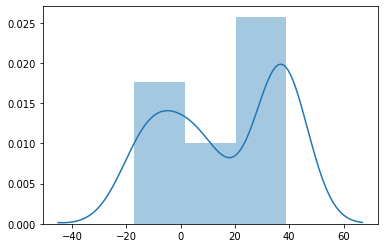

In [195]:
sns.distplot(crnngan_curriculum.generated_songs[-3][0][:,0])

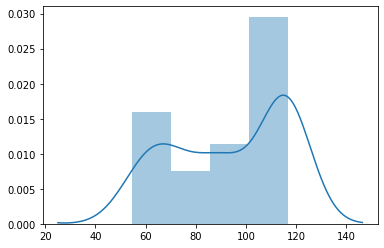

In [196]:
sns.distplot(crnngan_curriculum.generated_songs[-3][0][:,1])

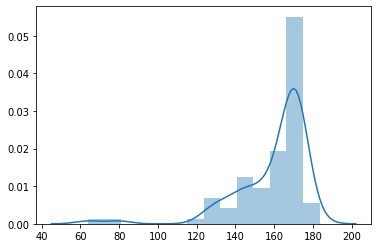

In [197]:
sns.distplot(crnngan_curriculum.generated_songs[-3][0][:,2])

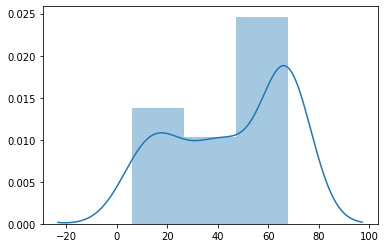

In [198]:
sns.distplot(crnngan_curriculum.generated_songs[-3][0][:,3])

The distributions start to look different depending on the variable!!

In [199]:
musicDataLoader.save_data('./test_curriculum_song2.midi', crnngan_curriculum.generated_songs[-3][0].numpy())

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=37, channel=0, data=[52, 67]),
   midi.NoteOnEvent(tick=0, channel=0, data=[51, 31]),
   midi.NoteOnEvent(tick=37, channel=0, data=[50, 28]),
   midi.NoteOnEvent(tick=1, channel=0, data=[52, 67]),
   midi.NoteOnEvent(tick=23, channel=0, data=[53, 58]),
   midi.NoteOffEvent(tick=20, channel=0, data=[51, 0]),
   midi.NoteOnEvent(tick=18, channel=0, data=[52, 68]),
   midi.NoteOffEvent(tick=14, channel=0, data=[50, 0]),
   midi.NoteOffEvent(tick=2, channel=0, data=[52, 0]),
   midi.NoteOnEvent(tick=23, channel=0, data=[52, 68]),
   midi.NoteOffEvent(tick=17, channel=0, data=[52, 0]),
   midi.NoteOnEvent(tick=11, channel=0, data=[49, 17]),
   midi.NoteOnEvent(tick=2, channel=0, data=[52, 36]),
   midi.NoteOffEvent(tick=3, channel=0, data=[53, 0]),
   midi.NoteOnEvent(tick=3, channel=0, data=[53, 67]),
   midi.NoteOnEvent(tick=33, channel=0, data=[52, 68])

In [64]:
import seaborn as sns

I think the net is not getting that there are different variables... Let's take a look at the distribution of all the variables concatenated.

If we are to compare in the same range, we seem to get somewhat similar distributions, however, we are leaving out lots of values. Further analysis has to be carried out to reach any conclusion.

Some ideas to get a better performance 
- Try to build a RNN that is able to distinguish between composers (or genres if composers is too hard) and then use similar architectures to model the generator network and the distriminator network.

- Try other values for the variance threshold.

- Try building the model on just one composer so that the variance is reduced.

I'll try with the simplest of the options which is just trining with one composer.

In [200]:
mozartDataLoader = music_data_utils.MusicDataLoader('./music_data', 0.2, 0.1, single_composer='mozart')

Data loader: datadir: ./music_data
num genres:1
num composers: 1
limit works per composer: None
appending classical/mozart/1584morzcondma.mid
appending classical/mozart/2249phantasieSteven.mid
appending classical/mozart/mozk545a.mid
appending classical/mozart/1787gpk136b.mid
appending classical/mozart/366fantsy_c.mid
appending classical/mozart/moz_k299.mid
appending classical/mozart/369sonat_a3.mid
appending classical/mozart/2017mozk299no1.mid
appending classical/mozart/2916requm1.mid
appending classical/mozart/k452.mid
appending classical/mozart/mozk545b.mid
appending classical/mozart/4321_duett.mid
appending classical/mozart/mozk545c.mid
appending classical/mozart/264diesirae.mid
appending classical/mozart/mozk175a.mid
appending classical/mozart/mozk211b.mid
appending classical/mozart/mozk246b.mid
appending classical/mozart/mozk246c.mid
appending classical/mozart/mozk211c.mid
appending classical/mozart/72.mid
appending classical/mozart/mozk175b.mid
appending classical/mozart/659andan

In [218]:
batch_length = 20
sequence_length = 20
in_channels_g = 20
out_channels_g = 4
hidden_dim_g = 350
### In the paper they indicate they've done it with 2, but it does not seem enough to get the complexity
### of the data.
n_layers_g = 3
in_channels_d = 4
out_channels_d = 2
hidden_dim_d = 350
n_layers_d = 2
variance_threshold = 2e-2
epochs = 60
print_every = 5

crnngan_mozart_curriculum = CRNNGAN(batch_length, sequence_length,
                 in_channels_g, out_channels_g, hidden_dim_g, n_layers_g,
                 in_channels_d, out_channels_d, hidden_dim_d, n_layers_d,
                 curriculum_learning = True, 
                 G_var_threshold=variance_threshold, D_var_threshold=variance_threshold,
                 epochs=epochs, print_every=print_every)

In [219]:
crnngan_mozart_curriculum.trainloop(mozartDataLoader)

Start training for 60 epochs
[0/60][0]	Loss_D: 6.0048	Loss_G: 3.7213	D(x): -2.9652	D(G(z)): -2.9947 / -0.00
 Time since epoch started: 0.66
There are a total of 0 fake songs saved already
[0/60][5]	Loss_D: 1.8465	Loss_G: 5.7092	D(x): -0.5289	D(G(z)): -1.3176 / -1.29
 Time since epoch started: 7.85
There are a total of 3 fake songs saved already
Epoch time: 7.85
[1/60][10]	Loss_D: 1.0675	Loss_G: 5.6492	D(x): -0.0334	D(G(z)): -1.0341 / -1.01
 Time since epoch started: 11.22
There are a total of 5 fake songs saved already
Epoch time: 14.21
[2/60][15]	Loss_D: 6.5229	Loss_G: 6.2787	D(x): -0.0087	D(G(z)): -0.1759 / -0.37
 Time since epoch started: 9.22
There are a total of 8 fake songs saved already
Epoch time: 11.53
[3/60][20]	Loss_D: 1.4470	Loss_G: 6.1986	D(x): -1.1612	D(G(z)): -0.2850 / -0.25
 Time since epoch started: 5.37
There are a total of 10 fake songs saved already
Epoch time: 11.81
[4/60][25]	Loss_D: 1.3820	Loss_G: 7.3292	D(x): -1.3379	D(G(z)): -0.0144 / -0.01
 Time since epoch st

Epoch time: 12.59
[38/60][230]	Loss_D: 1.4327	Loss_G: 0.7456	D(x): -0.5761	D(G(z)): -0.5646 / -0.50
 Time since epoch started: 6.30
There are a total of 115 fake songs saved already
Epoch time: 12.72
[39/60][235]	Loss_D: 1.4077	Loss_G: 0.6940	D(x): -0.6077	D(G(z)): -0.5836 / -0.56
 Time since epoch started: 4.31
There are a total of 118 fake songs saved already
New sequence length:  30  modified on iteration  240
The variances were 0.00080 for G and 0.00060 for D
Epoch time: 13.11
[40/60][240]	Loss_D: 1.4034	Loss_G: 0.7081	D(x): -0.6681	D(G(z)): -0.6453 / -0.66
 Time since epoch started: 2.64
There are a total of 120 fake songs saved already
[40/60][245]	Loss_D: 1.3953	Loss_G: 0.7137	D(x): -0.6791	D(G(z)): -0.6547 / -0.66
 Time since epoch started: 15.48
There are a total of 123 fake songs saved already
New sequence length:  35  modified on iteration  246
The variances were 0.00022 for G and 0.00010 for D
Epoch time: 15.48
[41/60][250]	Loss_D: 1.4004	Loss_G: 0.7359	D(x): -0.6294	D(G(z)

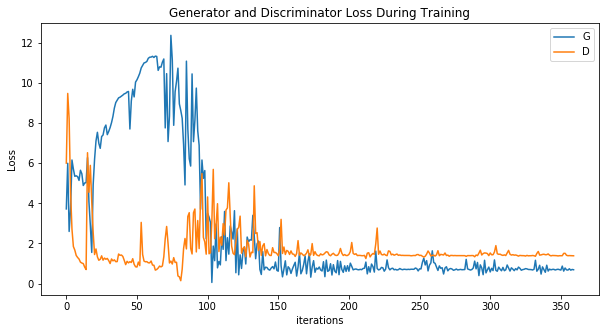

In [220]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(crnngan_mozart_curriculum.G_losses,label="G")
plt.plot(crnngan_mozart_curriculum.D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

We've been able to reach convergence for sequence length 85, however, for sequence length 90 it seems we have not had enough time, therefore we'll be saving a song with sequence length 85.

In [222]:
for i in range(len(crnngan_mozart_curriculum.generated_songs)):
    print('Song number: ', i)
    print(crnngan_mozart_curriculum.generated_songs[i].shape)

Song number:  0
torch.Size([20, 20, 4])
Song number:  1
torch.Size([20, 20, 4])
Song number:  2
torch.Size([20, 20, 4])
Song number:  3
torch.Size([20, 20, 4])
Song number:  4
torch.Size([20, 20, 4])
Song number:  5
torch.Size([20, 20, 4])
Song number:  6
torch.Size([20, 20, 4])
Song number:  7
torch.Size([20, 20, 4])
Song number:  8
torch.Size([20, 20, 4])
Song number:  9
torch.Size([20, 20, 4])
Song number:  10
torch.Size([20, 20, 4])
Song number:  11
torch.Size([20, 20, 4])
Song number:  12
torch.Size([20, 20, 4])
Song number:  13
torch.Size([20, 20, 4])
Song number:  14
torch.Size([20, 20, 4])
Song number:  15
torch.Size([20, 20, 4])
Song number:  16
torch.Size([20, 20, 4])
Song number:  17
torch.Size([20, 20, 4])
Song number:  18
torch.Size([20, 20, 4])
Song number:  19
torch.Size([20, 20, 4])
Song number:  20
torch.Size([20, 20, 4])
Song number:  21
torch.Size([20, 20, 4])
Song number:  22
torch.Size([20, 20, 4])
Song number:  23
torch.Size([20, 20, 4])
Song number:  24
torch.Siz

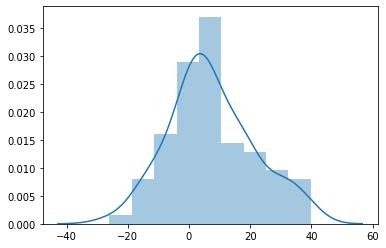

In [223]:
sns.distplot(crnngan_mozart_curriculum.generated_songs[-1][0][:,0])

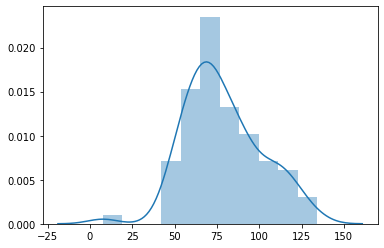

In [224]:
sns.distplot(crnngan_mozart_curriculum.generated_songs[-1][0][:,1])

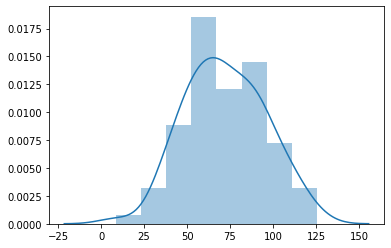

In [225]:
sns.distplot(crnngan_mozart_curriculum.generated_songs[-1][0][:,2])

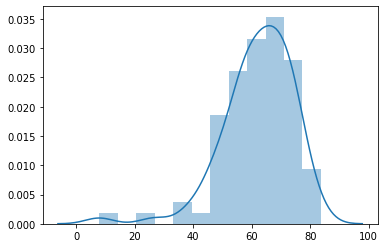

In [226]:
sns.distplot(crnngan_mozart_curriculum.generated_songs[-1][0][:,3])

It seems that we've been able to differentiate between the different variables. We might want to check how they look like for a real random sample.

In [227]:
mozartDataLoader.rewind('train')

In [228]:
batch_length = 20
sequence_length = 85
_, batch_data = mozartDataLoader.get_batch(batchsize=batch_length, songlength=sequence_length)

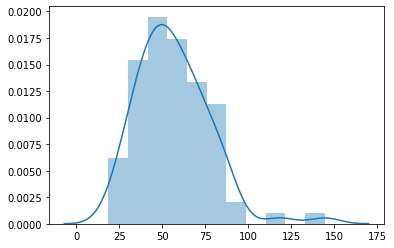

In [232]:
sns.distplot(batch_data.mean(axis=0)[:,0])

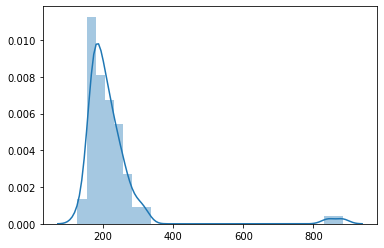

In [233]:
sns.distplot(batch_data.mean(axis=0)[:,1])

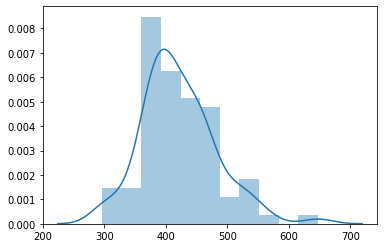

In [234]:
sns.distplot(batch_data.mean(axis=0)[:,2])

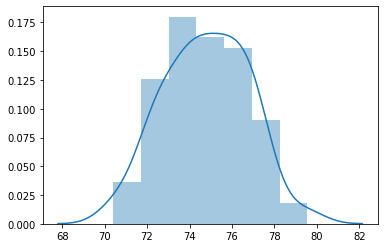

In [235]:
sns.distplot(batch_data.mean(axis=0)[:,3])

Obviously and as can be noted we are not being able to construct such large values for variables 2 and 3. To solve this something we can do is **normalize the values**.

In [236]:
mozartDataLoader.save_data('./pred_mozart.midi', crnngan_mozart_curriculum.generated_songs[-1][0].numpy())

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=-13, channel=0, data=[40, 62]),
   midi.NoteOnEvent(tick=8, channel=0, data=[44, 68]),
   midi.NoteOnEvent(tick=1, channel=0, data=[47, 77]),
   midi.NoteOnEvent(tick=8, channel=0, data=[32, 56]),
   midi.NoteOnEvent(tick=23, channel=0, data=[27, 61]),
   midi.NoteOnEvent(tick=14, channel=0, data=[33, 39]),
   midi.NoteOnEvent(tick=3, channel=0, data=[32, 65]),
   midi.NoteOnEvent(tick=5, channel=0, data=[35, 38]),
   midi.NoteOnEvent(tick=1, channel=0, data=[35, 64]),
   midi.NoteOffEvent(tick=12, channel=0, data=[32, 0]),
   midi.NoteOnEvent(tick=1, channel=0, data=[35, 71]),
   midi.NoteOnEvent(tick=5, channel=0, data=[43, 74]),
   midi.NoteOnEvent(tick=12, channel=0, data=[25, 54]),
   midi.NoteOffEvent(tick=1, channel=0, data=[40, 0]),
   midi.NoteOffEvent(tick=2, channel=0, data=[27, 0]),
   midi.NoteOnEvent(tick=3, channel=0, data=[24, 58]),
  

In [239]:
mozartDataLoader.save_data('./real_mozart.midi', batch_data[-1])

midi.Pattern(format=1, resolution=384, tracks=\
[midi.Track(\
  [midi.SetTempoEvent(tick=0, data=[20, 88, 85]),
   midi.NoteOnEvent(tick=96, channel=0, data=[79, 77]),
   midi.NoteOnEvent(tick=0, channel=0, data=[74, 77]),
   midi.NoteOnEvent(tick=0, channel=0, data=[71, 77]),
   midi.NoteOnEvent(tick=0, channel=0, data=[55, 82]),
   midi.NoteOnEvent(tick=96, channel=0, data=[62, 82]),
   midi.NoteOffEvent(tick=92, channel=0, data=[79, 0]),
   midi.NoteOffEvent(tick=0, channel=0, data=[74, 0]),
   midi.NoteOffEvent(tick=0, channel=0, data=[71, 0]),
   midi.NoteOffEvent(tick=0, channel=0, data=[55, 0]),
   midi.NoteOffEvent(tick=0, channel=0, data=[62, 0]),
   midi.NoteOnEvent(tick=4, channel=0, data=[62, 82]),
   midi.NoteOffEvent(tick=92, channel=0, data=[62, 0]),
   midi.NoteOnEvent(tick=4, channel=0, data=[62, 82]),
   midi.NoteOffEvent(tick=92, channel=0, data=[62, 0]),
   midi.NoteOnEvent(tick=4, channel=0, data=[81, 77]),
   midi.NoteOnEvent(tick=0, channel=0, data=[74, 77]),
   